In [1]:
# %load_ext jupyter_black
# %load_ext autoreload
# %autoreload 2

In [2]:
import sys

sys.path.append("..")

## Modeling

In [3]:
import pandas as pd
from utils.utils import set_seed

set_seed()

### Load data

In [4]:
ds_train = pd.read_csv("../data/avila/avila-tr.txt", header=None)
ds_test = pd.read_csv("../data/avila/avila-ts.txt", header=None)

### Models

In [5]:
%pip install sklvq

Note: you may need to restart the kernel to use updated packages.


In [6]:
# -- Required models --

# KNN
from sklearn.neighbors import KNeighborsClassifier

# LVQ
from sklvq import GLVQ

# Decision Tree
from sklearn.tree import DecisionTreeClassifier

# SVM
from sklearn.svm import SVC

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# MLP
from sklearn.neural_network import MLPClassifier

# Ensemble
from sklearn.ensemble import VotingClassifier

# -- Optional models --

# XGBoost
from xgboost import XGBClassifier

In [7]:
# -- Auxiliar functions --

from time import time


# Compute Training Time
class Timer:
    def __init__(self):
        self.start = time()

    def __call__(self):
        return time() - self.start

### Training

In [8]:
# Metrics
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

# import label encoder
from sklearn.preprocessing import LabelEncoder


# Compute metrics
def compute_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average="macro", zero_division=1),
        "recall": recall_score(y_true, y_pred, average="macro", zero_division=1),
        "f1": f1_score(y_true, y_pred, average="macro", zero_division=1),
    }


# Split data
X_train = ds_train.iloc[:, :-1]
y_train = ds_train.iloc[:, -1]
X_test = ds_test.iloc[:, :-1]
y_test = ds_test.iloc[:, -1]

label_encoder = LabelEncoder().fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

#### Training - Baseline

In [9]:
%%time

models = [
    KNeighborsClassifier(),
    GLVQ(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    MLPClassifier(),
]

models_results = {model.__class__.__name__: {} for model in models}

for model in models:
    print("Training model: ", model.__class__.__name__)

    timer = Timer()
    model.fit(X_train, y_train)
    metrics = compute_metrics(y_test, model.predict(X_test))
    metrics["fit_time"] = timer()
    models_results[model.__class__.__name__] = metrics

Training model:  KNeighborsClassifier
Training model:  GLVQ
Training model:  SVC
Training model:  DecisionTreeClassifier
Training model:  RandomForestClassifier
Training model:  XGBClassifier
Training model:  MLPClassifier
Wall time: 34.2 s


c:\Users\willi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [10]:
models_results = pd.DataFrame(models_results).T
models_results

,accuracy,precision,recall,f1,fit_time
KNeighborsClassifier,0.749545,0.809206,0.665667,0.718285,0.930041
GLVQ,0.543451,0.404941,0.434118,0.376341,14.730860
SVC,0.674523,0.820989,0.532343,0.569366,9.475802
DecisionTreeClassifier,0.969340,0.958798,0.964713,0.961587,0.060616
RandomForestClassifier,0.983999,0.990656,0.981099,0.985795,1.897979
XGBClassifier,0.998275,0.994999,0.997022,0.995981,2.165896
MLPClassifier,0.790649,0.826146,0.768335,0.784845,4.959805


### Stratified KFold

In [11]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

def stratified_cross_val(model_list, data, n_folds=30, n_splits=10):
    model_results = {type(model).__name__: [] for model in model_list}

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

    X = data.iloc[:, :-1]
    y = LabelEncoder().fit_transform(data.iloc[:, -1])

    for model in model_list:
        pipeline = Pipeline(
            [
                # ("scaler", StandardScaler()), # uncomment to scale data
                ("model", model)
            ]
        )

        for _ in range(n_folds):
            iter_scores = cross_validate(
                pipeline,
                X,
                y,
                cv=cv,
                scoring={
                    "f1_score": "f1_macro",
                    "precision_score": "precision_macro",
                    "accuracy_score": "accuracy",
                    "recall_score": "recall_macro",
                },
                n_jobs=-1,
            )
            model_results[type(model).__name__].append(iter_scores)

    return model_results



def model_results_to_df(model_results):
    res_final = pd.DataFrame(
        columns=[
            "fit_time",
            "score_time",
            "test_f1_score",
            "test_precision_score",
            "test_accuracy_score",
            "test_recall_score",
            "split",
            "model",
        ]
    )

    for model in model_results.keys():
        for i in range(len(model_results[model])):
            _res = pd.DataFrame(
                model_results[model][i].values(),
                index=model_results[model][i].keys(),
            ).T
            _res["split"] = i
            _res["model"] = model
            res_final = pd.concat([res_final, _res])

    return res_final

In [12]:
models = [
    KNeighborsClassifier(),
    GLVQ(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    MLPClassifier(),
]

stratified_crossval_results = model_results_to_df(
    stratified_cross_val(models, ds_train, n_folds=10, n_splits=5)
)

stratified_crossval_results.head().style

,fit_time,score_time,test_f1_score,test_precision_score,test_accuracy_score,test_recall_score,split,model
0,0.012022,0.192405,0.663541,0.718637,0.709492,0.628822,0,KNeighborsClassifier
1,0.011027,0.200163,0.664320,0.781919,0.721477,0.607114,0,KNeighborsClassifier
2,0.011527,0.184641,0.658006,0.734501,0.722435,0.613426,0,KNeighborsClassifier
3,0.011025,0.179048,0.681189,0.759278,0.732502,0.636757,0,KNeighborsClassifier
4,0.009968,0.218437,0.688243,0.791610,0.732502,0.634474,0,KNeighborsClassifier


### Metrics

In [13]:
stratified_crossval_results.groupby("model").mean(numeric_only=True).style

,fit_time,score_time,test_f1_score,test_precision_score,test_accuracy_score,test_recall_score
model,,,,,,
DecisionTreeClassifier,0.041016,0.005065,0.928128,0.930608,0.961860,0.929238
GLVQ,13.848811,0.005812,0.369934,0.407235,0.545705,0.432707
KNeighborsClassifier,0.011201,0.207039,0.671850,0.757833,0.721572,0.624547
MLPClassifier,4.622846,0.006352,0.765764,0.812438,0.774813,0.743829
RandomForestClassifier,1.658748,0.043116,0.971163,0.981228,0.980240,0.962186
SVC,2.444388,1.314244,0.560026,0.754558,0.670853,0.521846
XGBClassifier,4.944788,0.034092,0.987463,0.987404,0.996750,0.989765


In [14]:
stratified_crossval_results.groupby("model").std(numeric_only=True).style

,fit_time,score_time,test_f1_score,test_precision_score,test_accuracy_score,test_recall_score
model,,,,,,
DecisionTreeClassifier,0.001540,0.000411,0.036151,0.036205,0.011628,0.037130
GLVQ,0.276129,0.001020,0.013388,0.020554,0.009173,0.010647
KNeighborsClassifier,0.001793,0.017021,0.016680,0.023674,0.007809,0.016491
MLPClassifier,0.067241,0.000863,0.020379,0.022105,0.010380,0.021956
RandomForestClassifier,0.056170,0.004815,0.020998,0.019567,0.003389,0.022967
SVC,0.095110,0.131326,0.040043,0.056323,0.022501,0.034500
XGBClassifier,0.103529,0.002749,0.015556,0.018573,0.001325,0.012805


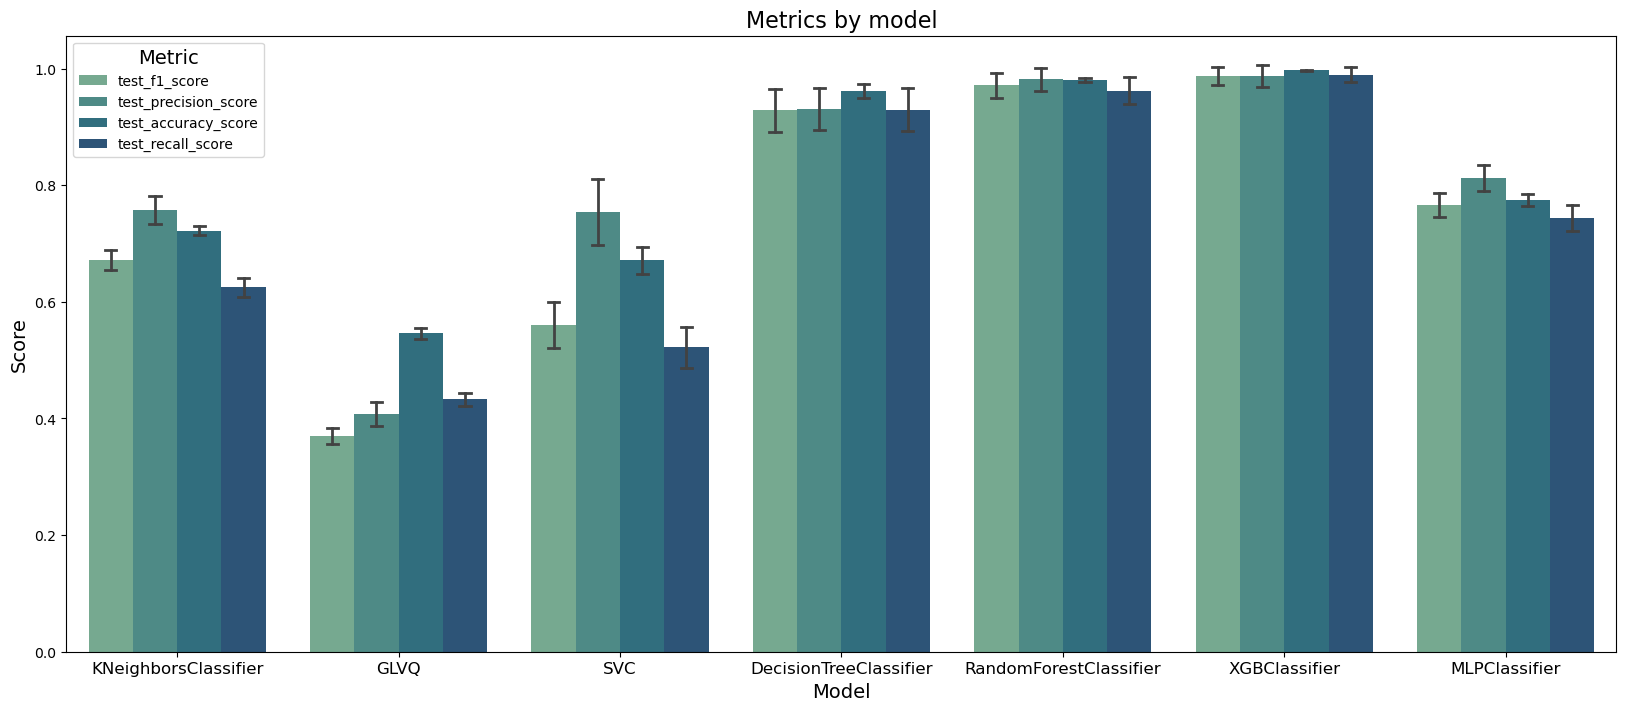

In [15]:
# Plot metrics average with confidence intervals

import matplotlib.pyplot as plt
import seaborn as sns

results_long = stratified_crossval_results.melt(
    id_vars=["split", "model"],
    value_vars=[
        "test_f1_score",
        "test_precision_score",
        "test_accuracy_score",
        "test_recall_score",
    ],
    var_name="metric",
    value_name="score",
)

plt.figure(figsize=(20, 8))
sns.barplot(
    data=results_long, x="model", y="score", hue="metric", errorbar="sd", errwidth=2, capsize=0.05, palette="crest")
plt.title("Metrics by model", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.xticks(fontsize=12)
plt.legend(title="Metric", title_fontsize="14", loc="upper left")
plt.show()

### Friedman and Nemeyni Tests

In [16]:
import numpy as np
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_nemenyi_friedman


def perform_friedman_nemenyi_tests(df):
    metrics = [
        "test_f1_score",
        "test_precision_score",
        "test_accuracy_score",
        "test_recall_score",
    ]
    models = df["model"].unique()
    folds = df["split"].unique()

    results = {}
    for metric in metrics:
        results[metric] = np.zeros((len(models), len(folds)))
        for i, model in enumerate(models):
            for j, fold in enumerate(folds):
                results[metric][i, j] = df.loc[
                    (df["model"] == model) & (df["split"] == fold)
                ][metric].values[0]

    # Friedman test
    for metric in metrics:
        stat, p_value = friedmanchisquare(*results[metric])
        print(f"{metric}: Friedman Chi Square = {stat:.3f}, p-value = {p_value:.3f}")
        if p_value < 0.05:
            print("Significant difference between models\n")
        else:
            print("No significant difference between models")

    # Nemenyi test
    for metric in metrics:
        posthoc = posthoc_nemenyi_friedman(results[metric].T)
        print(f"\nNemenyi PostHoc Test for {metric}:")
        print(posthoc)


perform_friedman_nemenyi_tests(stratified_crossval_results)

test_f1_score: Friedman Chi Square = 59.314, p-value = 0.000
Significant difference between models

test_precision_score: Friedman Chi Square = 56.186, p-value = 0.000
Significant difference between models

test_accuracy_score: Friedman Chi Square = 59.614, p-value = 0.000
Significant difference between models

test_recall_score: Friedman Chi Square = 59.614, p-value = 0.000
Significant difference between models


Nemenyi PostHoc Test for test_f1_score:
          0         1         2         3         4         5         6
0  1.000000  0.371715  0.900000  0.371715  0.016133  0.001624  0.900000
1  0.371715  1.000000  0.900000  0.001000  0.001000  0.001000  0.031341
2  0.900000  0.900000  1.000000  0.031341  0.001000  0.001000  0.371715
3  0.371715  0.001000  0.031341  1.000000  0.869118  0.503923  0.900000
4  0.016133  0.001000  0.001000  0.869118  1.000000  0.900000  0.254909
5  0.001624  0.001000  0.001000  0.503923  0.900000  1.000000  0.057739
6  0.900000  0.031341  0.371715  0.900

### Box-Plot Analysis

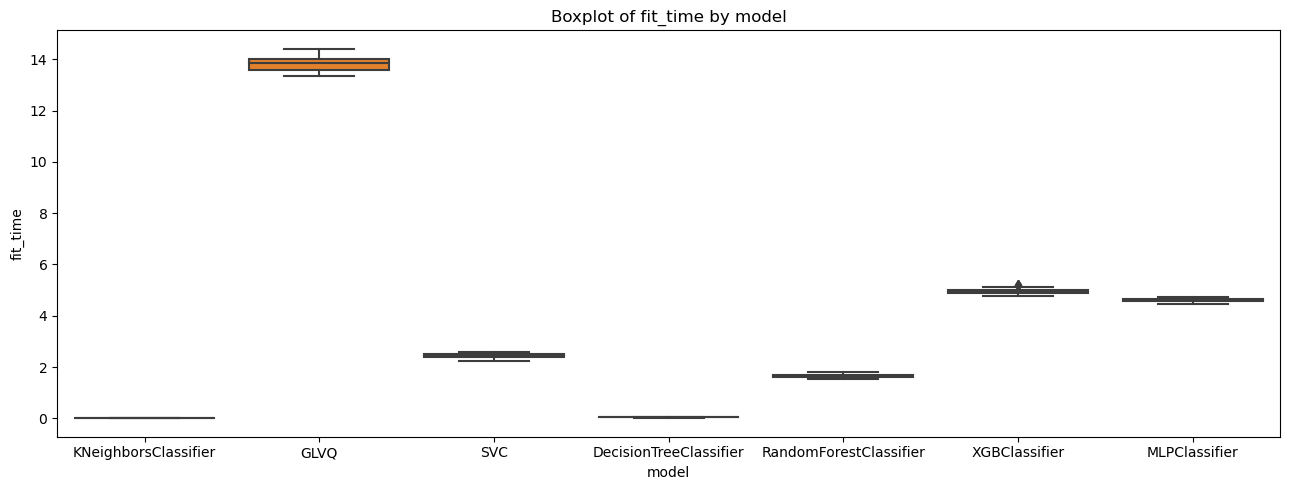

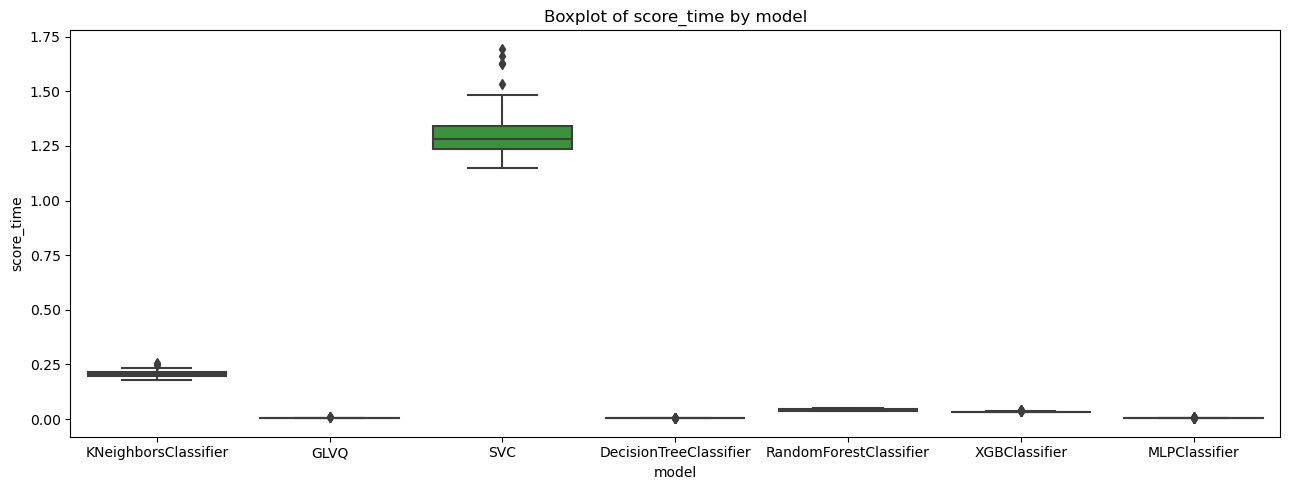

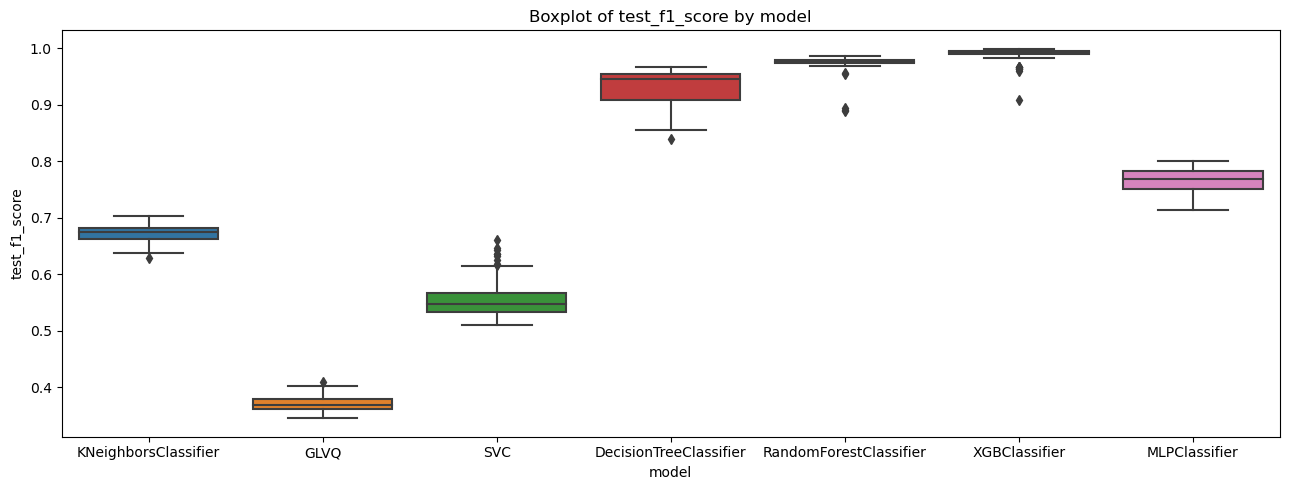

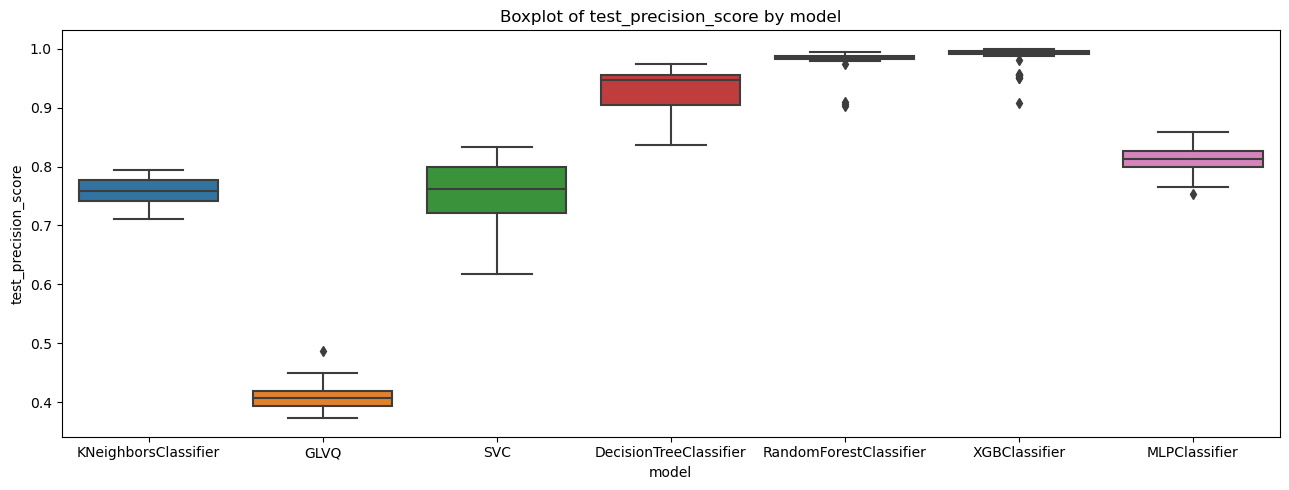

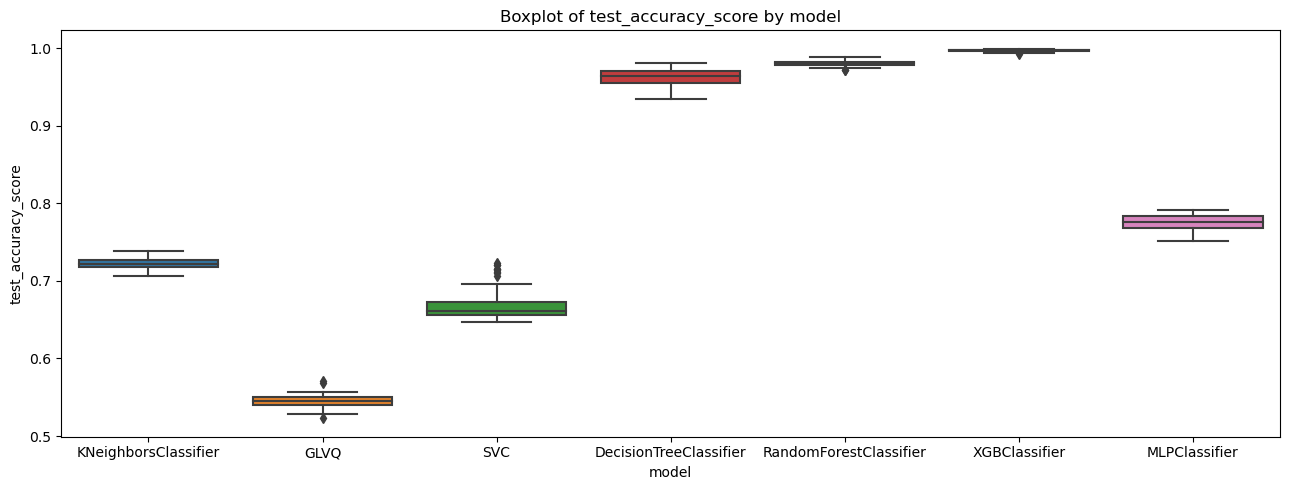

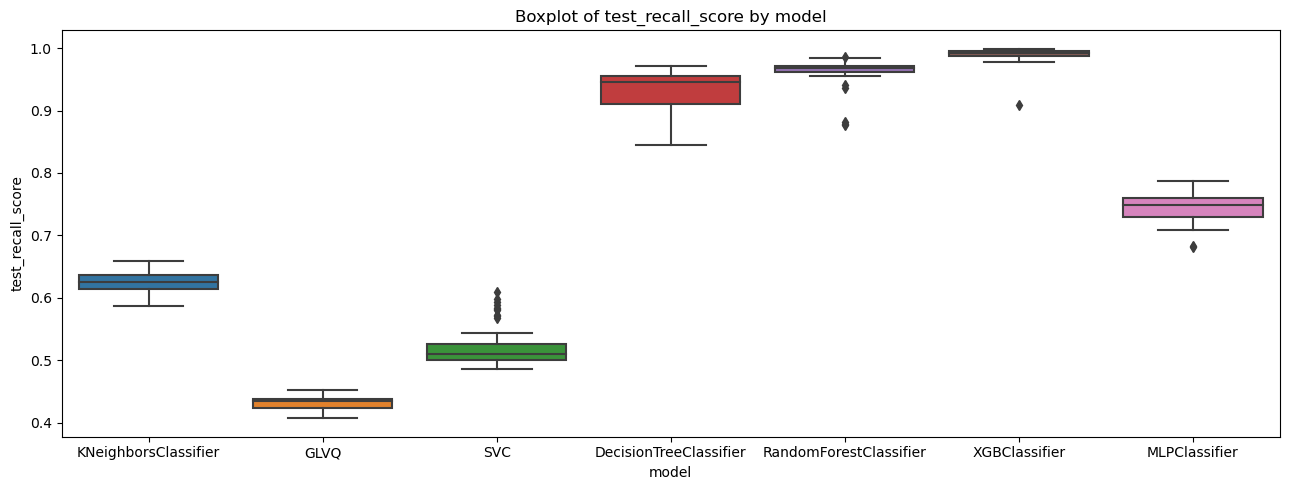

In [17]:
# Analyse models with boxplots

# metrics to be analyzed
metrics = ['fit_time', 'score_time', 'test_f1_score', 'test_precision_score', 'test_accuracy_score', 'test_recall_score']

# create a separate plot for each metric
for metric in metrics:
    plt.figure(figsize=(13, 5))
    sns.boxplot(x='model', y=metric, data=stratified_crossval_results)
    plt.title(f'Boxplot of {metric} by model')
    plt.xticks()  # rotate x-axis labels
    plt.tight_layout()
    plt.show()



### Confusion Matrix

In [18]:
# Fit models for comparison (when hyperparameters are tunned, pass tunning params to the model)

models = [
    KNeighborsClassifier(),
    GLVQ(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    MLPClassifier(),
]

models_results = {model.__class__.__name__: {} for model in models}

for model in models:
    print("Training model: ", model.__class__.__name__)

    timer = Timer()
    model.fit(X_train, y_train)
    metrics = compute_metrics(y_test, model.predict(X_test))
    metrics["fit_time"] = timer()
    models_results[model.__class__.__name__] = metrics

Training model:  KNeighborsClassifier
Training model:  GLVQ
Training model:  SVC
Training model:  DecisionTreeClassifier
Training model:  RandomForestClassifier
Training model:  XGBClassifier
Training model:  MLPClassifier


c:\Users\willi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


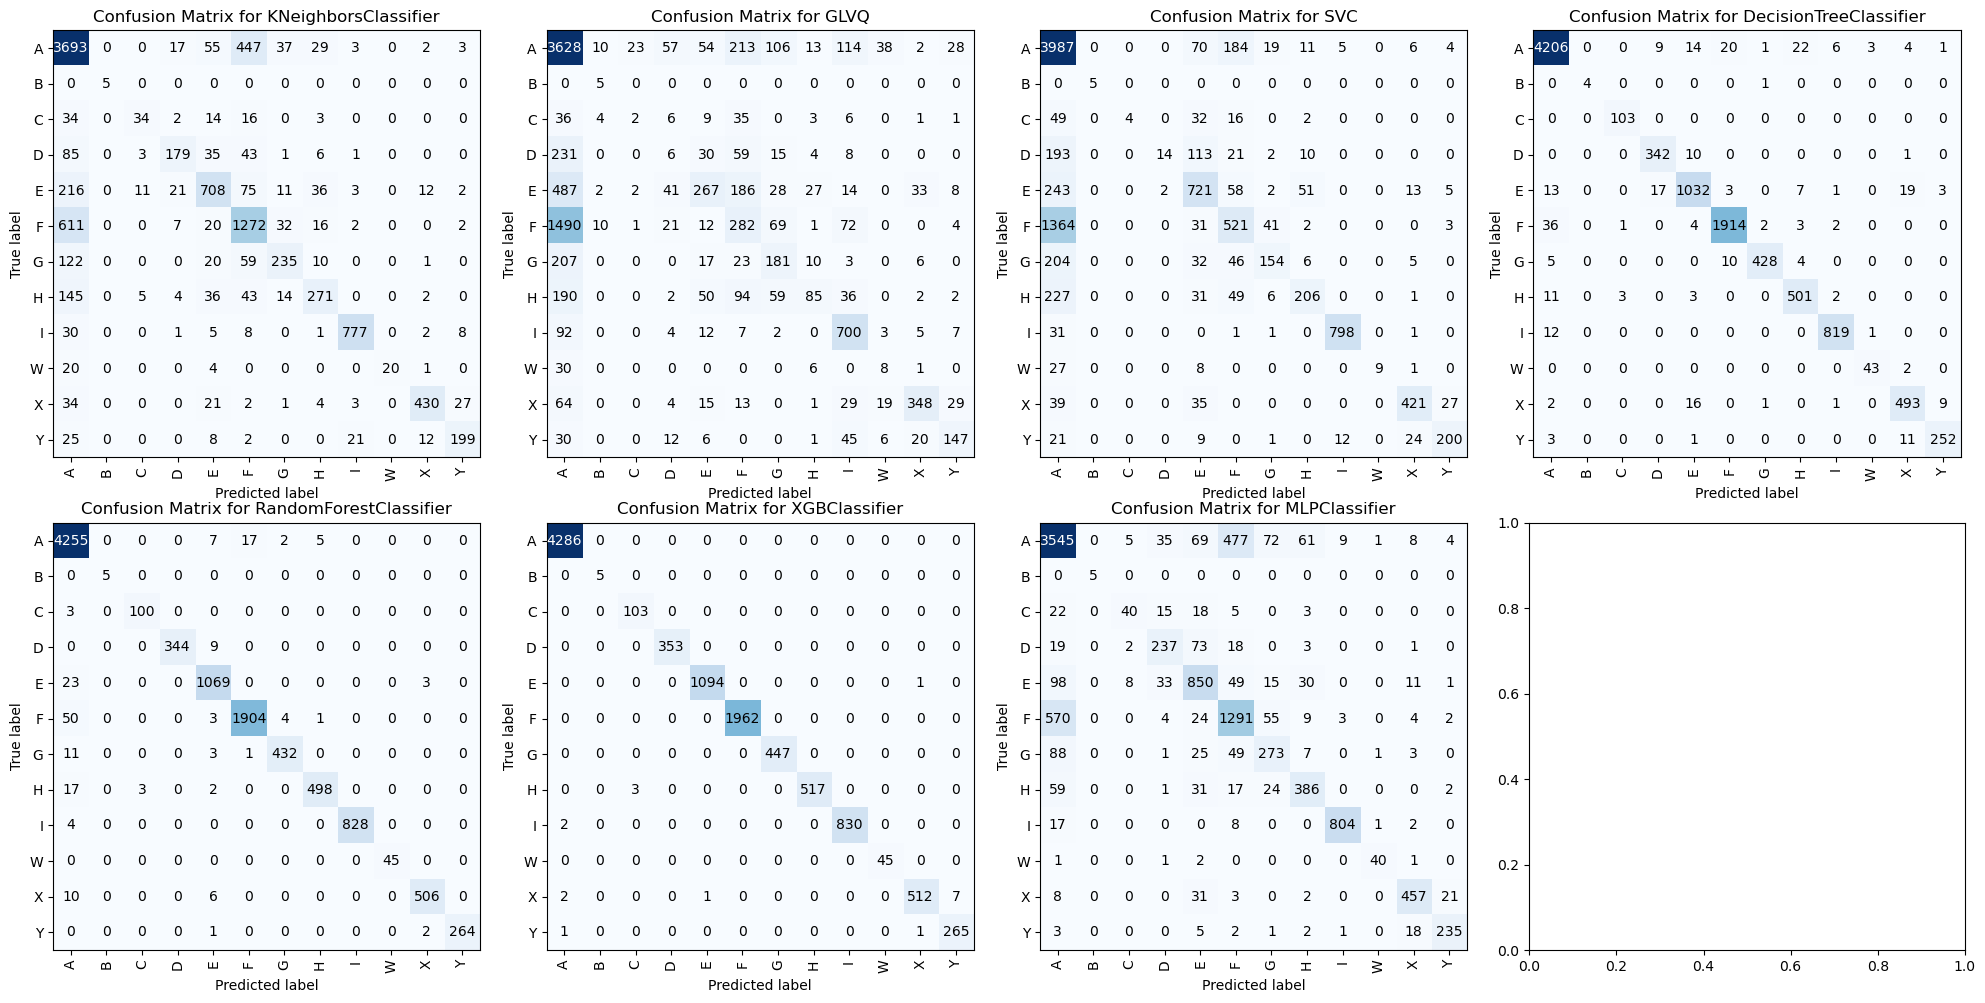

In [19]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test, normalize=None, ax=None):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize=normalize)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    
    ax.imshow(cm, cmap=plt.cm.Blues)
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if normalize == 'true':
                text = f'{cm[i, j]:.2f}'
            else:
                text = str(cm[i, j])
            ax.text(j, i, text, ha="center", va="center", color="white" if cm[i, j] > cm.max()/2 else "black")

    ax.set_xticks(range(len(label_encoder.classes_)))
    ax.set_xticklabels(label_encoder.classes_, rotation=90)
    ax.set_yticks(range(len(label_encoder.classes_)))
    ax.set_yticklabels(label_encoder.classes_)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(f"Confusion Matrix for {model.__class__.__name__}")
    return ax


fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, model in enumerate(models):
    plot_confusion_matrix(model, X_test, y_test, ax=axes[i // 4, i % 4])
plt.tight_layout()
